In [338]:
#uncomment this to see the names of the different configurations that can be loaded in
from config import *

fieldlist=[]
for info in field._registry:
    fieldlist.append(info.name)
print('Names of available configurations for fields:, ', fieldlist)

mosaiclist=[]
for info in mosaic._registry:
    mosaiclist.append(info.name)
print('\nNames of available configurations for mosaics:, ', mosaiclist)

Names of available configurations for fields:,  ['Field1', 'Field2', 'Field3', 'Field5', 'Field6', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'Field12', 'Field13', 'FieldA', 'FieldB', 'FieldC', 'FieldD', 'FieldE', 'FieldF', 'FieldG', 'FieldH', 'FieldI', 'FieldK', 'FieldL', 'FieldM', 'FieldO', 'FieldP', 'FieldQ', 'FieldR', 'FieldS', 'FieldT', 'FieldU', 'FieldV', 'FieldW', 'FieldX', 'FieldY', 'H_North', 'H_South', 'ArchE', 'ArchNE', 'ArchNW', 'ArchSE', 'ArchW']

Names of available configurations for mosaics:,  ['Mosaic25', 'Mosaic37']


In [339]:
#import configuration for selected file
from config import Field3 as field
from config import wavelength, segdetsig, finddetsig, bkgbox #import additional common paramters
from config import dpath, dpathalt, ds9path #import additional common paramters

In [340]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join
from astropy.coordinates import SkyCoord

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground, SExtractorBackground, MMMBackground
from photutils.utils import calc_total_error

from regions import read_ds9

In [341]:
from photutils.psf import BasicPSFPhotometry
from photutils.background import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
#from photutils.detection import DAOStarFinder, IRAFStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter
from photutils.datasets import make_gaussian_sources_image
from astropy.nddata import Cutout2D

In [342]:
#change directory to data location - provide alternate if working between two different pc's
try:
    os.chdir(dpath)
except:
    os.chdir(dpathalt)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(field.filename)
header=hdu[0].header

#pull the first image plane
ims=hdu[0].data

#use the first image plane shape to determine how to unpack the rest of the data
if len(np.shape(ims))==2:
    data=ims
    varmap=hdu[1].data
    tmap=hdu[2].data
elif len(np.shape(ims))==3:
    data=ims[0]
    varmap=ims[1]
    tmap=ims[2]
    hdu[0].header['NAXIS']=2 #hack to make non-standard WCS work with astropy
hdu.close()

#define wcs object for header
wcsmap=WCS(hdu[0].header)

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

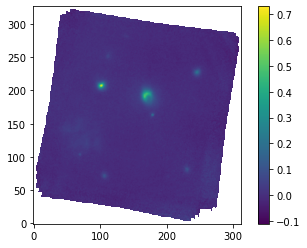

In [343]:
plt.figure()
plt.imshow(data,origin='lower')
plt.colorbar()
plt.show()

In [344]:
#load in the catalog files if they exist
if os.path.isfile(field.name+'_'+str(wavelength)+'um_segCat.dat'):
    segTab=ascii.read(field.name+'_'+str(wavelength)+'um_segCat.dat')
else:
    segTab=None
    
if os.path.isfile(field.name+'_'+str(wavelength)+'um_daoCat.dat'):   
    daoTab=ascii.read(field.name+'_'+str(wavelength)+'um_daoCat.dat')
else:
    daoTab=None

In [345]:
#create background model for image using median method
bkg_estimator = MedianBackground() #MMMBackground() #SExtractorBackground() #MedianBackground()
bkg_data = Background2D(data,(bkgbox, bkgbox), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = segdetsig*bkg_rms

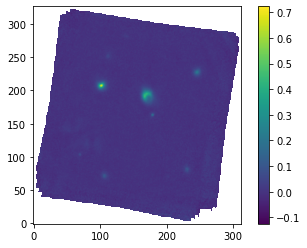

In [346]:
plt.figure()
plt.imshow(data_bkgsub,origin='lower')
plt.colorbar()
plt.show()

In [347]:
#remove nans to make life easier...
data_bkgsub[np.isnan(data_bkgsub)]=0

In [348]:
def dopsfphoto(image,bkgmodel,sources,sigma_init): 
	
	daogroup = DAOGroup(crit_separation=8)
	mmm_bkg = MedianBackground() #MedianBackground()#MMMBackground()
	fitter = LevMarLSQFitter()
	gaussian_prf = IntegratedGaussianPRF(sigma=sigma_init)
	gaussian_prf.sigma.fixed = False
	mmm_bkg.sigma_clip.fixed = False
	
	basic_phot_obj=BasicPSFPhotometry(group_maker=daogroup, bkg_estimator=None, psf_model=gaussian_prf, fitter=fitter, fitshape=(15, 15))
	
	photB_results = basic_phot_obj(image,init_guesses=sources) #must provide initial guesses as an astropy table with columns x_0 and y_0 in pixel coords
	
	
	results=photB_results[photB_results['flux_fit']>0]
	results=results[(results['sigma_fit']>0) & (results['sigma_fit']<14) ]
	
	sources = Table()
	sources['flux'] = results['flux_fit']
	sources['x_mean'] = results['x_fit']
	sources['y_mean'] = results['y_fit']
	sources['x_stddev'] = results['sigma_fit']
	sources['y_stddev'] = sources['x_stddev']
	#sources['theta'] = [0] * 2
	
	modelimage = make_gaussian_sources_image(np.shape(data), sources)
	
	#residual=data-modelimage
	residual=data-(modelimage+bkgmodel) #include bkg model   
	    
	chivals=[]
	
	for source in photB_results:
		spos=(np.int(source['x_fit']),np.int(source['y_fit']))
		cutout=Cutout2D(residual,spos,15)
		#print(np.sum(cutout.data))
		fudge=100.
		chivals.append((np.nansum(cutout.data)/21.)**2*100)
		
	photB_results['psfFitChi']=chivals
	#print(chivals)
	
	#rename flux initial guess in table 
	photB_results.rename_column('flux', 'flux_init')
	    
	    
	return photB_results, residual#, chivals

In [349]:
#create initial guess positions for fitting routine
posSeg=Table()
posSeg['x_0']=segTab['xcentroid']
posSeg['y_0']=segTab['ycentroid']
posSeg['flux']=segTab['aper_snr_6as']

#create initial guess positions for fitting routine
posDao=Table()
posDao['x_0']=daoTab['xcentroid']
posDao['y_0']=daoTab['ycentroid']
posDao['flux']=daoTab['aper_snr_4as']

In [350]:
posDao

x_0,y_0,flux
float64,float64,float64
245.0,38.03,-0.4695965389198692
248.5,37.23,-0.5860750322348345
191.7,50.4,-0.03266227095915283
106.3,72.02,14.975829973400483
225.2,74.47,2.0362506051570173
211.0,79.09,0.4651813159946238
230.3,81.7,13.630576246425731
69.84,103.9,2.5736222034826377
236.2,108.9,0.8100924052374631


In [351]:
dpsfresult,residual_dao=dopsfphoto(data_bkgsub,bkg,posDao,3.0)
spsfresult,residual_seg=dopsfphoto(data_bkgsub,bkg,posSeg,4.0)

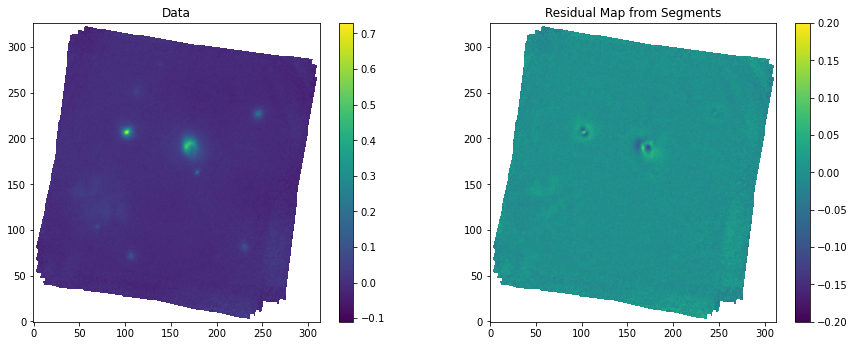

In [352]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Data')
p1=ax1.imshow(data,origin='lower')
fig.colorbar(p1, ax=ax1)


ax2.set_title('Residual Map from Segments')
p2=ax2.imshow(residual_seg,origin='lower',vmin=-0.2,vmax=0.2)
fig.colorbar(p2, ax=ax2)

plt.show()

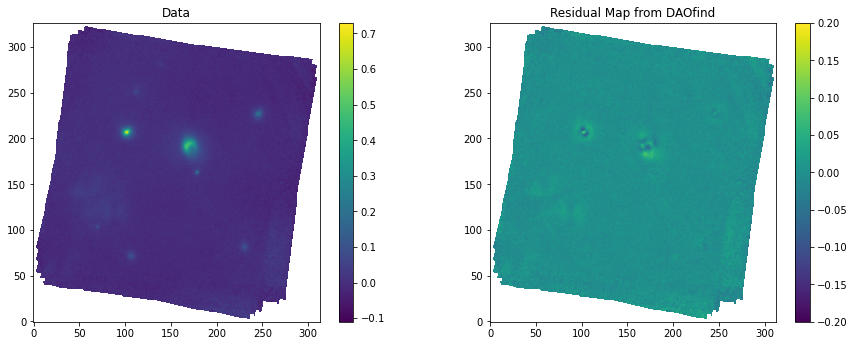

In [353]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Data')
p1=ax1.imshow(data,origin='lower')
fig.colorbar(p1, ax=ax1)


ax2.set_title('Residual Map from DAOfind')
p2=ax2.imshow(residual_dao,origin='lower',vmin=-0.2,vmax=0.2)
fig.colorbar(p2, ax=ax2)

plt.show()

In [354]:
spsfresult

x_0,y_0,flux_init,flux_0,sigma_0,id,group_id,x_fit,y_fit,flux_fit,sigma_fit,flux_unc,x_0_unc,y_0_unc,sigma_unc,psfFitChi
float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
106.7,72.09,15.927933762822741,6.821822134114674,4.0,1,1,106.60770620998983,71.95617076536686,6.662230185140934,3.260710935713808,0.1160880621258303,0.055872921403725,0.05582953738489123,0.04102256740474706,0.004617175123605086
229.8,81.79,15.075842267071756,6.520637393667,4.0,2,2,230.13874103471795,81.66838750516814,6.221590009613883,3.333663810150163,0.1480473825611949,0.0776390873326743,0.07767749512012757,0.0573662017445078,0.006193958044319643
69.76,103.9,2.4581995009174396,1.5928315666281119,4.0,3,3,69.7602476265166,103.90159098526632,1.178742011954974,1.5211558238960046,0.05038390567007341,0.06618290195001786,0.06618335912995518,0.04765987847530461,0.01922161550631951
95.82,120.0,2.7514367333411003,3.1902278757829,4.0,4,4,96.56882428666586,118.92575686447651,3.9549290156826213,5.33175552087877,0.2779199788269088,0.27304871846922674,0.27847672578006866,0.2687681931411646,0.0008198832567830192
79.77,119.8,1.504422546976587,3.0265698869860316,4.0,5,5,79.2142123718805,119.71112411493108,3.241604184067242,4.484328999152345,0.16902120202653786,0.20159654937861662,0.19977198866992218,0.17204427003893086,0.0013231392577860743
178.5,163.1,5.555366766889252,4.021105302490361,4.0,6,6,178.59866647688028,163.2655334456474,3.3258031498268217,1.7021633572382007,0.07243932334067658,0.037605297914382094,0.037605111368223657,0.026981624790029517,0.08471217652987839
170.0,193.1,20.27616334116917,63.04292368633726,4.0,7,7,169.2103523867254,193.13107402385762,87.13547124103626,5.785379289498852,2.516801306327926,0.1134380960128959,0.11158047145260731,0.11823203114279296,0.3940099005630884
102.1,207.5,28.244631226532626,44.38814836509622,4.0,8,8,101.87415966618268,207.1712184606345,42.143368434197455,3.3464771788804972,0.6117749235802127,0.047537525993674404,0.047542718400654375,0.03513599788236346,0.4535615416430224
245.3,227.2,36.50046705565907,15.968214618463215,4.0,9,9,245.33637347752162,227.17920443546444,15.931770649180441,3.6455191378784,0.2002822360541987,0.04384196537642548,0.043809123262537455,0.03339911048832439,0.01789591105948967


In [355]:
mtdao = join(daoTab,dpsfresult, keys='id')
mtseg = join(segTab,spsfresult, keys='id')

In [356]:
mtseg

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,skycoords,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,pixApArea,pixAnnArea,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv,x_0,y_0,flux_init,flux_0,sigma_0,group_id,x_fit,y_fit,flux_fit,sigma_fit,flux_unc,x_0_unc,y_0_unc,sigma_unc,psfFitChi
int32,float64,float64,str37,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str37,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,int32,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.7,72.09,"266.26324183719777,-29.29375761741625",0.01595,-0.004316,-0.5266,122,2.818,2.499,-60.51,0.1518,0.02926,0.1342,0.4619,0.1131,1.127,6.272,6.989,0.1697,1.525,5.545,0.1047,-0.004387,-0.004382,0.001416,17.14,"266.26324183719777,-29.29375761741625",1.7875722853017866,0.04373762277738656,4.266208278363678,0.08745831474111536,5.538678275298054,0.13112601614960723,5.615921365353293,0.17469471659462207,4.911452053302335,0.2183063231509118,-0.004485209919792609,-0.005261715752524448,6.398706491234399,0.13112601614960723,0.0,191.74759516631747,830.906245720709,15.927933762822741,1.8831309759613803,4.648443041002053,7.144860415906793,7.300419319792181,8.89109494099757,14.969422191191551,14.39477305279828,12.197110679854786,15.927933762822741,C7Field3,25,106.7,72.09,15.927933762822741,6.821822134114674,4.0,1,106.60770620998983,71.95617076536686,6.662230185140934,3.260710935713808,0.1160880621258303,0.055872921403725,0.05582953738489123,0.04102256740474706,0.004617175123605086
2,229.8,81.79,"266.23312889828406,-29.29168635700171",0.006265,0.001241,0.1266,102,2.88,2.144,-80.34,0.2147,0.03204,0.1233,0.6675,0.2554,1.343,5.978,6.965,0.2085,1.933,4.662,0.09911,0.001241,0.00132,0.0002363,9.643,"266.23312889828406,-29.29168635700171",1.722996713922248,0.04531476292969805,4.302451339973641,0.09061152932557583,6.149399720948388,0.13581545430749065,7.048323841715295,0.18095782161458532,7.482068283543705,0.2260144661513234,-7.480092696705291e-05,-0.000506421455543081,6.163742618810531,0.13581545430749065,0.0,191.74759516631747,830.906245720709,15.075842267071756,1.724590369240264,4.308825961245704,7.073822326803549,7.521909666494104,7.999602514297797,13.63217957206566,14.002849671409006,12.35100539472551,15.075842267071756,C7Field3,25,229.8,81.79,15.075842267071756,6.520637393667,4.0,2,230.13874103471795,81.66838750516814,6.221590009613883,3.333663810150163,0.1480473825611949,0.0776390873326743,0.07767749512012757,0.0573662017445078,0.006193958044319643
3,69.76,103.9,"266.2722848208022,-29.2869697913093",-0.004486,0.01291,0.271,21,1.18,1.078,-31.34,0.7564,0.1263,0.8216,0.4065,0.08635,1.095,2.662,1.407,0.1071,2.247,0.8779,0.0437,0.01289,0.01297,0.001423,1.561,"266.2722848208022,-29.2869697913093",1.133856658038569,0.044016417799736855,2.404690476223153,0.08801120437497709,3.8660609598173585,0.13199130107290805,5.775796326415437,0.17592425233635003,8.244444646557593,0.21983842503559384,0.005134273738104821,0.010255316899586064,2.8815763176101794,0.13199130107290805,0.005134273738104821,191.74759516631747,

In [357]:
#write out the resulting table to file
ascii.write(mtdao, field.name+'_25um_cat_daoprf.dat', overwrite=True)
ascii.write(mtseg, field.name+'_25um_cat_segprf.dat', overwrite=True)

In [358]:
fits.writeto(field.filename[:-12]+'resid_DAO.fits', residual_dao,overwrite=True)
fits.writeto(field.filename[:-12]+'resid_SEG.fits', residual_seg,overwrite=True)